Testing with `sorted_df.csv`



https://github.com/nlp-with-transformers/notebooks

### Tutorial: Generative QA with Retrieval-Augmented Generation

https://haystack.deepset.ai/tutorials/07_rag_generator



Logging

In [11]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)


Fetching and Cleaning Documents (csv file)


```
import pandas as pd
from haystack.utils import fetch_archive_from_http

# Download sample
doc_dir = "data/tutorial7/"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/small_generator_dataset.csv.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Create dataframe with columns "title" and "text"
df = pd.read_csv(f"{doc_dir}/small_generator_dataset.csv", sep=",")
# Minimal cleaning
df.fillna(value="", inplace=True)

print(df.head())
```

In [12]:
import pandas as pd
from haystack.utils import fetch_archive_from_http

# Specify the columns to include from the CSV file
columns_to_include = ['Questions', 'Answers', 'Context']

# Create the DataFrame from the CSV file, including only the specified columns
df = pd.read_csv('sorted_df.csv', usecols=columns_to_include)

# Minimal cleaning
df.fillna(value="", inplace=True)

print(df.head())


                                                                         Questions  \
0  Hello PCnetMD, I can't tell about the third party DIMMs but I was able to cr...   
1  In the latest 13G iDRAC firmware, 2.75.100.75, the initial web UI login now ...   
2  Before my question, below I show the equipment I'm usingPowerEdge R16102x In...   
3  The power supply on our PowerEdge T110 died so i replaced it with another, a...   
4  I am upgrading my Poweredge R630 with 10x32GB RAM, and have removed existing...   

                                                                           Answers  \
0  GreetingsI upgraded some R640 from 6.00.30.00 to 6.10.00.00.When clicking on...   
1  @Philip-R, This is an issue with iDRAC firmware 2.75.100.75. Next iDRAC firm...   
2  Check the specs on your CPU. The memory controller is built into the CPU chi...   
3  I got it fixed by posting here:https://community.spiceworks.com/topic/234360...   
4  Hi, Based on the user guide, you may need to popul

In [13]:
len(df)

102

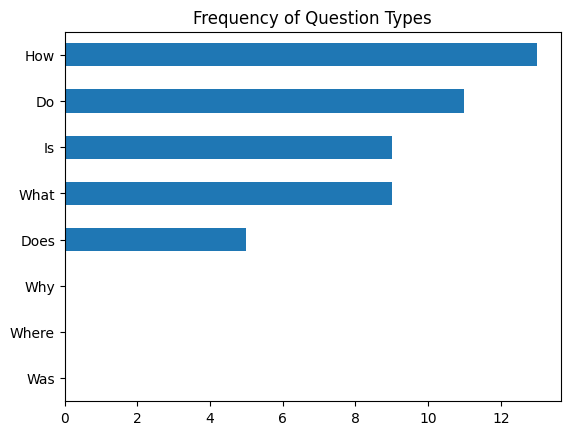

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = df["Questions"].str.contains(q).value_counts().get(True, 0)

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()


## Initalize Document Store (Elasticsearch) via Docker image


# Alternative if Docker is installed


The difference between the docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:8.6.1 command and from haystack.utils import launch_es lies in how Elasticsearch is launched and managed.

`docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:8.6.1:`

This command uses Docker to run an Elasticsearch container in detached mode (-d flag), exposing port 9200 on the host machine (-p 9200:9200). It pulls the elasticsearch:8.6.1 Docker image and runs a single-node Elasticsearch cluster (-e "discovery.type=single-node").
This approach allows you to run Elasticsearch within a Docker container, isolated from your host machine. It provides flexibility in managing the Elasticsearch environment but requires Docker installation and familiarity with Docker commands.
from haystack.utils import launch_es:



This Python code snippet imports the launch_es function from the haystack.utils module.
`launch_es()` is a convenience function provided by the Haystack library. It simplifies the process of starting an Elasticsearch instance locally within your Python environment.
When called, launch_es() starts an Elasticsearch instance using the default configuration, typically on localhost with port 9200. This approach is suitable for local development and testing purposes, as it doesn't require a separate Elasticsearch installation or Docker.
In summary, the docker run command is used to launch Elasticsearch within a Docker container, while launch_es() from Haystack allows you to start an Elasticsearch instance locally within your Python environment. The choice between the two depends on your specific requirements, familiarity with Docker, and the desired level of isolation and control over the Elasticsearch environment.




-------------------------

Run command below only (from the dir where eleastocsearch folder is saved)

`docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:8.6.1`

In [ ]:
!docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:8.6.1

or:

In [24]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

In [1]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [ ]:
## docker stop <container_id_or_name>
!docker stop 19437483d340

In [ ]:
!sudo docker stop 19437483d340

In [4]:
!curl -X GET "localhost:9200/?pretty"


{
  "name" : "19f8f6ef2078",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "zAX32hbFSh-8rLdfND_c-w",
  "version" : {
    "number" : "7.17.6",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "f65e9d338dc1d07b642e14a27f338990148ee5b6",
    "build_date" : "2022-08-23T11:08:48.893373482Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [17]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)
     

Documents now have a field content, which replaces the field text. This change was introduced because Documents have become more flexible and can also store tables in addition to texts.

In [18]:
# Get the document count
document_count = document_store.get_document_count()

# Print the count
print("Number of documents:", document_count)

Number of documents: 17


### continuing below from turtorial 

# Retriever

In [19]:
from haystack.nodes import RAGenerator, DensePassageRetriever

retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    use_gpu=True,
    embed_title=True,
)


INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
INFO:haystack.modeling.model.language_model:Auto-detected model language: english
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO:haystack.modeling.model.language_model:Auto-detected model language: english


# Generator

In [20]:
generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    use_gpu=True,
    top_k=1,
    max_length=200,
    min_length=2,
    embed_title=True,
    num_beams=2,
)


INFO:haystack.modeling.utils:Using devices: CPU - Number of GPUs: 0
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this check

In [10]:
df.head()

NameError: name 'df' is not defined

# Writing Documents to Document_Store (ElasticsearchDocumentStore)


```
WARNING - haystack.document_stores.elasticsearch -  Index is empty. First add some documents to search them.
WARNING - haystack.document_stores.elasticsearch -  No documents with embeddings. Run the document store's update_embeddings() method.
```

- Two indices, `document` and `label` (answers pans.
- Below we are just populating `document` index (and optional `meta` fields, so can filter during Retrival).

In [14]:
# Get the document count
document_count = document_store.get_document_count()

# Print the count
print("Number of documents:", document_count)

Number of documents: 0


/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:275: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  return response.status, response.getheaders(), raw_data


In [5]:

# It's a good idea to flush Elasticsearch with each notebook restart 
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")
     

NameError: name 'document_store' is not defined

Need to add our documents

In [ ]:
for split, df in df.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

In [15]:
# Populate document index with 'Context' field
documents = []
for _, row in df.iterrows():
    docs = [
        {
            "content": row["Context"],
            "meta": {
                "questions": row["Questions"],
                "answers": row["Answers"]
            }
        }
    ]
    documents.extend(docs)

# Write documents to the document store
document_store.write_documents(documents=documents, index="document")

# Print the count of loaded documents
document_count = document_store.get_document_count(index="document")
print(f"Loaded {document_count} documents")

Loaded 17 documents


```
# Delete existing documents in documents store
document_store.delete_documents()

# Write documents to document store
document_store.write_documents(df)

# Add documents embeddings to index
document_store.update_embeddings(retriever=retriever)
```

# Initializing the Pipeline

In [21]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=retriever)


# Asking a Question


In [22]:
from haystack.utils import print_answers

In [23]:
QUESTIONS = [
    "helo, my iDRAC is broken after an update"
]

for question in QUESTIONS:
    res = pipe.run(query=question, params={"Generator": {"top_k": 1}, "Retriever": {"top_k": 5}})
    print_answers(res, details="minimum")

Traceback (most recent call last):
  File "/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py", line 245, in perform_request
    response = self.pool.urlopen(
  File "/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    retries = retries.increment(
  File "/home/cian/anaconda3/envs/qa/lib/pytho

Exception: Exception while running node 'Retriever': ConnectionError(<urllib3.connection.HTTPConnection object at 0x7feab1e03e20>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7feab1e03e20>: Failed to establish a new connection: [Errno 111] Connection refused)
Enable debug logging to see the data that was passed when the pipeline failed.